In [19]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [11]:
train0 = pd.read_pickle('D:\\CS760\\pj\\train_set_0.pkl')
train1 = pd.read_pickle('D:\\CS760\\pj\\train_set_1.pkl')
train2 = pd.read_pickle('D:\\CS760\\pj\\train_set_2.pkl')
train_set = pd.concat([train0,train1], ignore_index=True)
training = pd.concat([train_set,train2], ignore_index=True)
testset =  pd.read_pickle('D:\\CS760\\pj\\train_set_2.pkl')

In [12]:
device = ['Chrome','Firefox','Opera','Safari','Edge','Android Browser','Seznam','Samsung Internet','Internet Explorer',
          'UC Browser','YaBrowser','Amazon Silk','BlackBerry','Coc Coc','Mozilla','Maxthon', 'Nintendo Browser',
         'Playstation Vita Browser', 'Nokia Browser','MRCHROME','SeaMonkey','Puffin']

In [13]:
training['device_browser'].replace({'Opera Mini':'Opera', 'Safari (in-app)':'Safari', 'Android Webview':'Android Browser',
                                   'Mozilla Compatible Agent':'Mozilla'}, inplace=True)
training.loc[~training['device_browser'].isin(device),'device_browser']='others'
testset['device_browser'].replace({'Opera Mini':'Opera', 'Safari (in-app)':'Safari', 'Android Webview':'Android Browser',
                                   'Mozilla Compatible Agent':'Mozilla'}, inplace=True)
testset.loc[~testset['device_browser'].isin(device),'device_browser']='others'

In [14]:
trainset = training.sample(frac=3/4,random_state=101)
validset = training.loc[~training.index.isin(trainset.index), :]

In [15]:
def ordinal(data):
    categorical = ['channelGrouping','device_browser','device_operatingSystem','geoNetwork_country']
    boolean = ['trafficSource_adwordsClickInfo.isVideoAd','trafficSource_isTrueDirect']
    for col in categorical:
        attributes = data[col].unique()
        d = dict(enumerate(attributes,start=1))
        new = dict((v,k) for k,v in d.items())
        data[col].replace(new,inplace = True)
    for col in boolean:
        data[col].replace({True:1,False:0},inplace=True)
    return data

def standardize(TrainSet,TestSet):
    standard=np.array(TrainSet)
    standard_test=np.array(TestSet)
    mean_array=np.mean(standard,axis=0)
    stdev=np.std(standard,axis=0,ddof=1)
    if stdev==0:
        stdev=1
    outcome = (standard_test - mean_array) / stdev
    return outcome

In [16]:
def GetData(A, B):
    dataset1 = A.copy()
    dataset2 = B.copy()
    
    ID = dataset1[['fullVisitorId']]
    # y = log(1+revenue)
    dataset1['totals_transactionRevenue'] = np.log(dataset1['totals_transactionRevenue']+1)
    dataset2['totals_transactionRevenue'] = np.log(dataset2['totals_transactionRevenue']+1)
    
    # ordinal encoding categorical features  
    dataset1 = ordinal(dataset1)
    
    # standardize numerical features
    numerical = ['totals_hits','totals_pageviews','totals_sessionQualityDim','totals_timeOnSite',
                 'totals_transactionRevenue','totals_transactions']
    for col in numerical:
        #standardize dataset1 based on dataset2
        dataset1[col]=standardize(dataset2[col],dataset1[col]) 
    # load y
    train_y = dataset1[['totals_transactionRevenue']]
    
    y = torch.tensor(train_y.values)
    # load x
    train_x = dataset1.drop(['totals_transactionRevenue','fullVisitorId','visitStartTime'], axis=1)
    x = torch.tensor(train_x.to_numpy(dtype=np.float))   
    return x,y,ID    

In [17]:
train_x, train_y, train_ID = GetData(trainset,trainset)
valid_x, valid_y, valid_ID = GetData(validset,trainset)
test_x, test_y, test_ID = GetData(testset,trainset)

In [20]:
class FourLayerNet(nn.Module):

    def __init__(self, D_in, H1, H2, H3, drop):
        super(FourLayerNet, self).__init__()
        self.linear1 = nn.Linear(D_in, H1)
        self.linear2 = nn.Linear(H1, H2)
        self.linear3 = nn.Linear(H2, H3)
        self.linear4 = nn.Linear(H3, 1)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        hidden_layer1 = self.drop(F.softmax(self.linear1(x.float())) )        
        hidden_layer2 = self.drop(F.softmax(self.linear2(hidden_layer1)))
        hidden_layer3 = self.drop(F.softmax(self.linear3(hidden_layer2)))
        y_pred = self.linear4(hidden_layer3)
        return y_pred

In [21]:
class FourLayerNet2(nn.Module):

    def __init__(self, D_in, H1, H2, H3):
        super(FourLayerNet2, self).__init__()
        self.linear1 = nn.Linear(D_in, H1)
        self.linear2 = nn.Linear(H1, H2)
        self.linear3 = nn.Linear(H2, H3)
        self.linear4 = nn.Linear(H3, 1)

    def forward(self, x):
        hidden_layer1 = F.softmax(self.linear1(x.float()))     
        hidden_layer2 = F.softmax(self.linear2(hidden_layer1))
        hidden_layer3 = F.softmax(self.linear3(hidden_layer2))
        y_pred = self.linear4(hidden_layer3)
        return y_pred

In [22]:
def train(model, x, y,criterion,optimizer):
    """
   train NN
    """
    model.train()
    y_pred = model(x)
    loss = criterion(y_pred.float(), y.float())
    print(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss.item()

def valid(model, x_valid, y_valid,criterion):
    """
    test NN
    """
    model.eval()
    y_pred = model(x_valid)
    loss = criterion(y_pred.float(), y_valid.float())
    #print(loss.item())
    return loss.item(),y_pred

In [24]:
model1 = FourLayerNet2(train_x.shape[1], 8, 8, 8)
optimizer = torch.optim.Adam(model1.parameters(), lr=0.1)
criterion = torch.nn.MSELoss()
loss_train=[]
for i in range(100):
    print(i,' ', end='')
    loss_train.append(train(model1,train_x,train_y,criterion,optimizer))
    
model1_loss = valid(model1, valid_x, valid_y,criterion)

0  

C:\Users\toycs\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\toycs\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
C:\Users\toycs\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]


1.079258680343628
1  1.0029268264770508
2  1.0154259204864502
3  1.0360568761825562
4  1.027834177017212
5  1.0097264051437378
6  0.9999664425849915
7  1.0035556554794312
8  1.0124098062515259
9  1.0155688524246216
10  1.010858178138733
11  1.0032988786697388
12  0.9985637664794922
13  0.99880051612854
14  1.0017527341842651
15  1.0031641721725464
16  1.0003827810287476
17  0.9937999248504639
18  0.9855383038520813
19  0.9773442149162292
20  0.9691226482391357
21  0.9585955142974854
22  0.9427967667579651
23  0.9210293889045715
24  0.8952301740646362
25  0.8680214285850525
26  0.8391491174697876
27  0.8080804944038391
28  0.7749338746070862
29  0.7419333457946777
30  0.7107739448547363
31  0.6799471378326416
32  0.6479706764221191
33  0.616759181022644
34  0.5874063968658447
35  0.5582260489463806
36  0.5287618637084961
37  0.500390887260437
38  0.47341999411582947
39  0.4468502104282379
40  0.420754611492157
41  0.3958848714828491
42  0.37227973341941833
43  0.34925925731658936
44  0.

In [25]:
model2 = FourLayerNet(train_x.shape[1], 8 , 8, 8, 0.2)
optimizer = torch.optim.Adam(model2.parameters(), lr=0.1)
criterion = torch.nn.MSELoss()
loss_train2=[]

for i in range(100):
    print(i,' ', end='')
    loss_train2.append(train(model2,train_x,train_y,criterion,optimizer))

model2_loss = valid(model2, valid_x, valid_y,criterion)

0  

C:\Users\toycs\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
C:\Users\toycs\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]
C:\Users\toycs\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


1.0303865671157837
1  1.004295825958252
2  1.0215983390808105
3  1.0111812353134155
4  1.0002758502960205
5  1.0021976232528687
6  1.0079376697540283
7  1.0068068504333496
8  1.0008318424224854
9  0.9970157146453857
10  0.9974839091300964
11  0.9984890818595886
12  0.9957401156425476
13  0.9892716407775879
14  0.9821072220802307
15  0.9756745100021362
16  0.969993531703949
17  0.9603498578071594
18  0.9484189748764038
19  0.9363006353378296
20  0.9256273508071899
21  0.9135787487030029
22  0.9008123874664307
23  0.8875018358230591
24  0.8713282942771912
25  0.8546858429908752
26  0.8349572420120239
27  0.8111588954925537
28  0.7875950336456299
29  0.7666641473770142
30  0.7467234134674072
31  0.7268604040145874
32  0.7096157073974609
33  0.6929029226303101
34  0.6743454933166504
35  0.654328465461731
36  0.6401466727256775
37  0.6195129156112671
38  0.6074470281600952
39  0.5953112840652466
40  0.5804072618484497
41  0.563563346862793
42  0.5478498935699463
43  0.5313900709152222
44  0

In [26]:
model3 = FourLayerNet(train_x.shape[1], 8, 8, 8, 0.4)
optimizer = torch.optim.Adam(model3.parameters(), lr=0.1)
criterion = torch.nn.MSELoss()
loss_train3=[]

for i in range(100):
    print(i,' ', end='')
    loss_train3.append(train(model3,train_x,train_y,criterion,optimizer))

model3_loss = valid(model3, valid_x, valid_y,criterion)

0  

C:\Users\toycs\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
C:\Users\toycs\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]
C:\Users\toycs\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


1.0245835781097412
1  1.0135879516601562
2  1.0168582201004028
3  1.0044009685516357
4  1.001998782157898
5  1.0065423250198364
6  1.00557279586792
7  1.001054286956787
8  0.9995201826095581
9  1.0018243789672852
10  1.002892017364502
11  1.0008207559585571
12  0.997832179069519
13  0.9968461394309998
14  0.9962653517723083
15  0.9942660927772522
16  0.9890722036361694
17  0.9850230813026428
18  0.9823305010795593
19  0.9792014360427856
20  0.972504734992981
21  0.9663310050964355
22  0.9593032598495483
23  0.9525089263916016
24  0.9451556205749512
25  0.9367307424545288
26  0.9241997599601746
27  0.9191738963127136
28  0.9074181318283081
29  0.8985010385513306
30  0.8887453675270081
31  0.8773730397224426
32  0.8655216097831726
33  0.8568605780601501
34  0.8471039533615112
35  0.838312566280365
36  0.8254194855690002
37  0.8177691698074341
38  0.8115345239639282
39  0.7977194786071777
40  0.7935963869094849
41  0.7870036959648132
42  0.7779590487480164
43  0.768253743648529
44  0.7672

In [27]:
model4 = FourLayerNet(train_x.shape[1], 8, 8, 8, 0.5)
optimizer = torch.optim.Adam(model4.parameters(), lr=0.1)
criterion = torch.nn.MSELoss()
loss_train4=[]

for i in range(100):
    print(i,' ', end='')
    loss_train4.append(train(model4,train_x,train_y,criterion,optimizer))

model4_loss = valid(model4, valid_x, valid_y,criterion)

0  

C:\Users\toycs\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
C:\Users\toycs\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]
C:\Users\toycs\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


1.1129673719406128
1  1.0186463594436646
2  1.0190871953964233
3  1.0418119430541992
4  1.0396702289581299
5  1.0233640670776367
6  1.0072530508041382
7  1.0021892786026
8  1.007842779159546
9  1.0144121646881104
10  1.0133506059646606
11  1.0067875385284424
12  1.0008126497268677
13  0.9992979764938354
14  1.0013411045074463
15  1.0030204057693481
16  1.0011584758758545
17  0.9967717528343201
18  0.9919300675392151
19  0.9898012280464172
20  0.9894267320632935
21  0.9882923364639282
22  0.9846404194831848
23  0.9783373475074768
24  0.9729695916175842
25  0.9673230051994324
26  0.9650375843048096
27  0.9596338272094727
28  0.9482360482215881
29  0.9437582492828369
30  0.9381992816925049
31  0.9195939302444458
32  0.9177883863449097
33  0.8982468843460083
34  0.8914315104484558
35  0.8756095767021179
36  0.8734056949615479
37  0.8523002862930298
38  0.8528892397880554
39  0.834367036819458
40  0.8380444645881653
41  0.80600905418396
42  0.8191422820091248
43  0.7988013625144958
44  0.79

Text(0.5, 1.0, '4 layer network: nodes number VS loss')

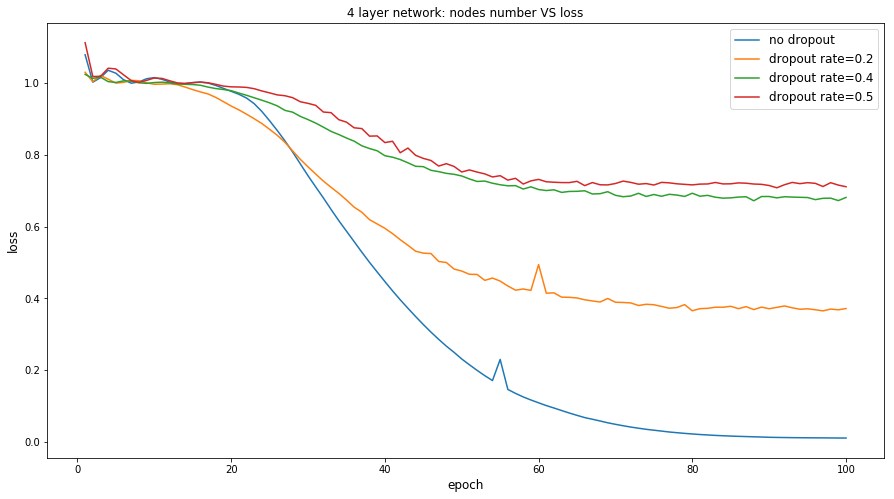

In [29]:
fig,ax = plt.subplots(figsize=(15,8))
ax.plot(range(1,101),loss_train,label = 'no dropout')
ax.plot(range(1,101),loss_train2,label = 'dropout rate=0.2')
ax.plot(range(1,101),loss_train3,label = 'dropout rate=0.4')
ax.plot(range(1,101),loss_train4,label = 'dropout rate=0.5')
ax.set_xlabel('epoch',fontsize='large')
ax.set_ylabel('loss',fontsize='large')
ax.legend(fontsize='large')
ax.set_title('4 layer network: nodes number VS loss')

In [32]:
model5 = FourLayerNet2(train_x.shape[1], 4,4,4)
optimizer = torch.optim.Adam(model5.parameters(), lr=0.1)
criterion = torch.nn.MSELoss()
loss_train5=[]

for i in range(100):
    print(i,' ', end='')
    loss_train5.append(train(model5,train_x,train_y,criterion,optimizer))
model5_loss = valid(model5,valid_x,valid_y,criterion)

0  

C:\Users\toycs\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\toycs\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
C:\Users\toycs\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]


1.2800090312957764
1  1.081892967224121
2  1.0034111738204956
3  1.0155829191207886
4  1.0588334798812866
5  1.0795711278915405
6  1.0701853036880493
7  1.045121192932129
8  1.0196459293365479
9  1.0035226345062256
10  0.9999812841415405
11  1.00640869140625
12  1.0164365768432617
13  1.023423433303833
14  1.0237947702407837
15  1.0180449485778809
16  1.0095537900924683
17  1.0025614500045776
18  1.0001877546310425
19  1.0028400421142578
20  1.0077921152114868
21  1.0110520124435425
22  1.0103795528411865
23  1.0065144300460815
24  1.001997470855713
25  0.9992155432701111
26  0.9990326166152954
27  1.0006022453308105
28  1.002181887626648
29  1.0022248029708862
30  0.9999921321868896
31  0.9955226182937622
32  0.9908045530319214
33  0.987560510635376
34  0.9846944212913513
35  0.9809297323226929
36  0.974879801273346
37  0.9659798741340637
38  0.9545901417732239
39  0.9413406252861023
40  0.9265686869621277
41  0.910449743270874
42  0.8917296528816223
43  0.8708201050758362
44  0.84790

In [37]:
model6 = FourLayerNet2(train_x.shape[1], 16,16,16)
optimizer = torch.optim.Adam(model6.parameters(), lr=0.1)
criterion = torch.nn.MSELoss()
loss_train6=[]

for i in range(100):
    print(i,' ', end='')
    loss_train6.append(train(model6,train_x,train_y,criterion,optimizer))
model6_loss = valid(model6,valid_x,valid_y,criterion)

0  

C:\Users\toycs\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\toycs\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
C:\Users\toycs\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]


1.0004433393478394
1  1.0430326461791992
2  1.0024117231369019
3  1.0091071128845215
4  1.0224217176437378
5  1.0134354829788208
6  1.000110387802124
7  0.9968064427375793
8  1.0019631385803223
9  1.004123330116272
10  0.9982155561447144
11  0.988544225692749
12  0.9807094931602478
13  0.9753554463386536
14  0.9679155349731445
15  0.9539926052093506
16  0.9341122508049011
17  0.9125115275382996
18  0.8925157785415649
19  0.872663676738739
20  0.8487786054611206
21  0.8199784159660339
22  0.7900499701499939
23  0.7622986435890198
24  0.7353081703186035
25  0.7061887383460999
26  0.6754849553108215
27  0.6456758379936218
28  0.6175593137741089
29  0.5896458625793457
30  0.5607511401176453
31  0.5318512916564941
32  0.5043478012084961
33  0.4779195189476013
34  0.45142149925231934
35  0.4249143898487091
36  0.3995308578014374
37  0.37563973665237427
38  0.35222163796424866
39  0.3289777636528015
40  0.30698829889297485
41  0.28638866543769836
42  0.2663062512874603
43  0.24681155383586884

In [38]:
model7 = FourLayerNet2(train_x.shape[1], 32,32,32)
optimizer = torch.optim.Adam(model7.parameters(), lr=0.1)
criterion = torch.nn.MSELoss()
loss_train7=[]

for i in range(100):
    print(i,' ', end='')
    loss_train7.append(train(model7,train_x,train_y,criterion,optimizer))
    
model7_loss = valid(model7,valid_x,valid_y,criterion)

0  

C:\Users\toycs\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\toycs\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
C:\Users\toycs\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]


1.0241577625274658
1  1.003178358078003
2  1.0179903507232666
3  1.0090909004211426
4  1.0002521276474
5  1.003056526184082
6  1.0082614421844482
7  1.0066066980361938
8  1.0015541315078735
9  0.9994332790374756
10  1.0013132095336914
11  1.0028204917907715
12  1.000558614730835
13  0.9956126809120178
14  0.9905819296836853
15  0.9858480095863342
16  0.9789271354675293
17  0.9668476581573486
18  0.9487961530685425
19  0.9262722134590149
20  0.9007002115249634
21  0.8720543384552002
22  0.8404127359390259
23  0.8070710301399231
24  0.7736827731132507
25  0.7398535013198853
26  0.7050153017044067
27  0.6706910729408264
28  0.6452637314796448
29  0.6038050651550293
30  0.5709147453308105
31  0.5391440391540527
32  0.5079942941665649
33  0.47752347588539124
34  0.4483273923397064
35  0.42044079303741455
36  0.39237555861473083
37  0.3657275140285492
38  0.3402748107910156
39  0.3155272305011749
40  0.29188933968544006
41  0.26935502886772156
42  0.247572660446167
43  0.22671040892601013
44

Text(0.5, 1.0, '4 layer network: nodes number VS loss')

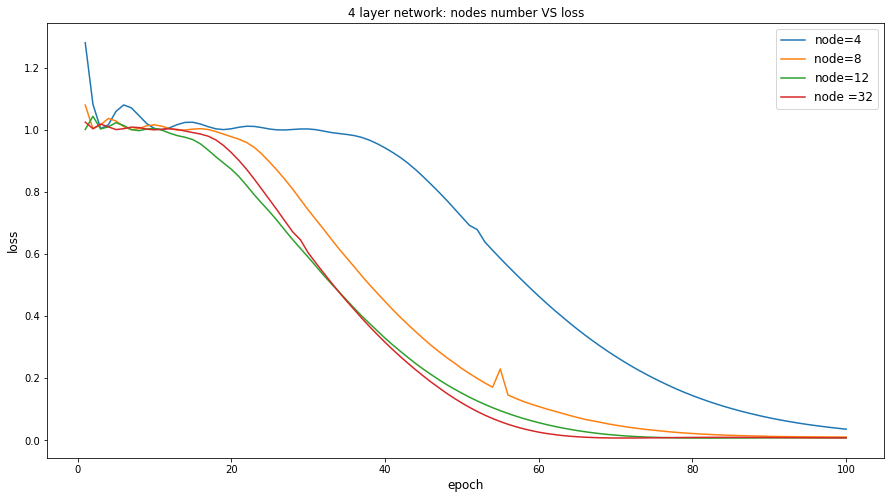

In [42]:
fig,ax = plt.subplots(figsize=(15,8))

ax.plot(range(1,101),loss_train5,label = 'node=4')
ax.plot(range(1,101),loss_train,label = 'node=8 ')
ax.plot(range(1,101),loss_train6,label = 'node=12')
ax.plot(range(1,101),loss_train7,label = 'node =32')
ax.set_xlabel('epoch',fontsize='large')
ax.set_ylabel('loss',fontsize='large')
ax.legend(fontsize='large')
ax.set_title('4 layer network: nodes number VS loss')

In [39]:
print('Model 1: 4 layer network with 8 nodes in each hidden layer, drop out rate = 0, validation MSE LOSS = ', model1_loss[0])
print('Model 2: 4 layer network with 8 nodes in each hidden layer, drop out rate = 0.2, validation MSE LOSS = ', model2_loss[0])
print('Model 3: 4 layer network with 8 nodes in each hidden layer, drop out rate = 0.4, validation MSE LOSS = ', model3_loss[0])
print('Model 4: 4 layer network with 8 nodes in each hidden layer, drop out rate = 0.5, validation MSE LOSS = ', model4_loss[0])
print('Model 5: 4 layer network with 4 nodes in each hidden layer, drop out rate = 0, validation MSE LOSS = ', model5_loss[0])
print('Model 6: 4 layer network with 16 nodes in each hidden layer, drop out rate = 0, validation MSE LOSS = ', model6_loss[0])
print('Model 7: 4 layer network with 32 nodes in each hidden layer, drop out rate = 0, validation MSE LOSS = ', model7_loss[0])

Model 1: 4 layer network with 8 nodes in each hidden layer, drop out rate = 0, validation MSE LOSS =  0.009796214289963245
Model 2: 4 layer network with 8 nodes in each hidden layer, drop out rate = 0.2, validation MSE LOSS =  0.05449821054935455
Model 3: 4 layer network with 8 nodes in each hidden layer, drop out rate = 0.4, validation MSE LOSS =  0.41831010580062866
Model 4: 4 layer network with 8 nodes in each hidden layer, drop out rate = 0.5, validation MSE LOSS =  0.2559935748577118
Model 5: 4 layer network with 4 nodes in each hidden layer, drop out rate = 0, validation MSE LOSS =  0.03356689587235451
Model 6: 4 layer network with 16 nodes in each hidden layer, drop out rate = 0, validation MSE LOSS =  0.006953184027224779
Model 7: 4 layer network with 32 nodes in each hidden layer, drop out rate = 0, validation MSE LOSS =  0.006639539729803801


In [40]:
test_loss,test_pred = valid(model7,test_x,test_y,criterion)

C:\Users\toycs\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\toycs\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
C:\Users\toycs\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]


In [41]:
print('test_loss:',test_loss)

0.007923543453216553

In [44]:
def restore(pred_y,trainset):
    standard =trainset[['totals_transactionRevenue']].values
    standard = np.log(standard+1)
    mean=np.mean(standard,axis=0)
    mean = mean[0]

    stdev=np.std(standard,axis=0,ddof=1)
    stdev = stdev[0]

    y = pred_y*stdev + mean
    y=y.detach().numpy()
    pred_revenue = np.exp(y)-1
    pred_revenue = np.where(pred_revenue<0.01,0,pred_revenue)
    return y, pred_revenue

In [45]:
r1,r2 = restore(test_pred,trainset)
test_ID['pred_revenue']=r2
test_ID['true_revenue']=testset['totals_transactionRevenue']
test_ID

,fullVisitorId,pred_revenue,true_revenue
138892,5010032653131027513,0.0,0.0
138893,8224664698359594721,0.0,0.0
138894,4765296453494895643,0.0,0.0
138895,4903219059240129204,0.0,0.0
138896,109606899040654516,0.0,0.0
138897,7340942839601994731,0.0,0.0
138898,2596624436473347088,0.0,0.0
138899,3093566724126253413,0.0,0.0
138900,4097555294720182704,0.0,0.0
138901,0272639494387064411,0.0,0.0


In [46]:
outcome = test_ID.groupby(['fullVisitorId']).sum()
outcome['pred_revenue']=np.log(outcome['pred_revenue']+1)
outcome['true_revenue']=np.log(outcome['true_revenue']+1)

In [47]:
outcome

,pred_revenue,true_revenue
fullVisitorId,,
0000027376579751715,0.0,0.0
0000039460501403861,0.0,0.0
0000040862739425590,0.0,0.0
0000049363351866189,0.0,0.0
0000062267706107999,0.0,0.0
0000085059828173212,0.0,0.0
0000114156543135683,0.0,0.0
0000117255350596610,0.0,0.0
0000130646294093000,0.0,0.0


In [48]:
outcome[outcome['true_revenue']>0]

,pred_revenue,true_revenue
fullVisitorId,,
0001376836098133431,18.022648,18.197412
0002871498069867123,18.022648,18.383498
0006911334202687206,18.022648,17.884537
0007617910709180468,18.022648,16.759423
0010295111715775250,18.022648,14.686804
0010664124684883628,18.715796,17.883511
0012224893830398338,18.022648,16.677711
0012561433643490595,18.022648,15.294840
0014262055593378383,18.022648,16.790019
